In [4]:
# Install required packages
# Note: TensorFlow memerlukan Long Path Support di Windows
# Jika gagal, aktifkan Long Path atau gunakan command berikut di PowerShell (sebagai Admin):
# New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force

%pip install imbalanced-learn -q
# Install TensorFlow - jika error, restart kernel setelah instalasi
%pip install tensorflow --no-cache-dir -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fasya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\fasya\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\fault_injection\\fault_injection_service_config_parser.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fasya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### ⚠️ Alternatif jika TensorFlow Gagal Install
Jika TensorFlow gagal install karena Long Path issue, gunakan salah satu solusi:
1. **Aktifkan Windows Long Path** (Run sebagai Admin di PowerShell):
   ```powershell
   New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
   ```
2. **Atau gunakan Scikit-learn MLPClassifier** (akan otomatis terdeteksi jika TensorFlow tidak tersedia)

## 📦 Package Installation
Jalankan cell ini jika package belum terinstall

# Deep Learning Pipeline for Fraud Detection
## Complete End-to-End Binary Classification using Feedforward Neural Network

## 📖 PANDUAN PENGGUNAAN

### ⚡ Cara Menjalankan Notebook:

**PENTING: Jalankan cell secara BERURUTAN dari atas ke bawah!**

1. ✅ **Cell 1-2**: Install packages (jalankan sekali saja)
2. ✅ **Cell 5**: Import libraries (WAJIB dijalankan pertama)
3. ✅ **Cell 6-8**: Load data
4. ✅ **Cell selanjutnya**: Ikuti urutan hingga selesai

### 🔴 Jika Muncul Error:

- **NameError (name 'pd' is not defined)** → Jalankan Cell 5 (Import Libraries) terlebih dahulu
- **MemoryError** → Lihat tips di section berikutnya atau gunakan Google Colab/Kaggle

---

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, precision_score, 
                              recall_score, confusion_matrix, classification_report, 
                              roc_curve, precision_recall_curve, auc)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Try to import TensorFlow, fallback to scikit-learn if not available
USE_TENSORFLOW = True
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Check GPU availability
    print("✓ TensorFlow tersedia!")
    print("TensorFlow version:", tf.__version__)
    print("GPU Available:", tf.config.list_physical_devices('GPU'))
    print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
except ImportError:
    USE_TENSORFLOW = False
    from sklearn.neural_network import MLPClassifier
    print("⚠️ TensorFlow tidak tersedia, menggunakan scikit-learn MLPClassifier sebagai alternatif")
    print("✓ Scikit-learn Neural Network akan digunakan")
    np.random.seed(42)

⚠️ TensorFlow tidak tersedia, menggunakan scikit-learn MLPClassifier sebagai alternatif
✓ Scikit-learn Neural Network akan digunakan


## 1. LOAD DATA

### ⚠️ PENTING: Memory Management & Urutan Eksekusi

**🚨 JALANKAN CELL SECARA BERURUTAN dari atas ke bawah!**

Dataset ini **sangat besar** (~1.7GB). Jika Anda mengalami **MemoryError**:

**✅ SOLUSI TERBAIK:**
1. **Google Colab** (12GB RAM gratis): https://colab.research.google.com
2. **Kaggle Notebooks** (16GB RAM gratis): https://www.kaggle.com/code

**🔧 SOLUSI LOKAL:**
1. **RESTART KERNEL** terlebih dahulu (penting!)
2. **Jalankan Cell 5 (Import Libraries)** sebelum cell ini
3. **Tutup semua aplikasi** lain
4. **Adjust sample_size** di cell berikut sesuai RAM Anda:
   - 4GB RAM → sample_size=25000
   - 8GB RAM → sample_size=50000 ✅ DEFAULT
   - 16GB+ RAM → sample_size=100000+

In [3]:
def load_data(sample_size=50000):
    """
    Load transaction data with aggressive memory optimization for low-RAM systems
    
    Parameters:
    -----------
    sample_size : int
        Number of rows to load (default: 50000 for low-RAM systems)
        Increase if you have more RAM (100000, 200000, etc.)
    """
    print(f"{'='*60}")
    print(f"LOADING DATA (MEMORY OPTIMIZED)")
    print(f"{'='*60}")
    print(f"\n⚙️ Loading {sample_size:,} rows from each dataset")
    print("   💡 Increase sample_size if you have more RAM\n")
    
    try:
        # Use Python engine which is slower but more memory efficient
        print("⚙️ Reading train_transaction.csv...")
        train_df = pd.read_csv(
            "train_transaction.csv",
            nrows=sample_size,
            engine='python',  # More memory efficient
            low_memory=True
        )
        
        print("✓ Train data loaded")
        
        print("\n⚙️ Reading test_transaction.csv...")
        # Load proportional test set
        test_sample = int(sample_size * 0.85)  # test is ~85% of train size
        test_df = pd.read_csv(
            "test_transaction.csv",
            nrows=test_sample,
            engine='python',
            low_memory=True
        )
        
        print("✓ Test data loaded")
        
        # Immediate memory optimization
        print("\n⚙️ Optimizing datatypes...")
        for col in train_df.select_dtypes(include=['float64']).columns:
            train_df[col] = train_df[col].astype('float32')
        
        for col in test_df.select_dtypes(include=['float64']).columns:
            test_df[col] = test_df[col].astype('float32')
        
        for col in train_df.select_dtypes(include=['int64']).columns:
            if col not in ['TransactionID']:
                train_df[col] = train_df[col].astype('int16')
        
        for col in test_df.select_dtypes(include=['int64']).columns:
            if col not in ['TransactionID']:
                test_df[col] = test_df[col].astype('int16')
        
        print("✓ Datatypes optimized")
        
    except Exception as e:
        print(f"\n❌ Error loading data: {e}")
        print("\n💡 SOLUTIONS:")
        print("   1. RESTART KERNEL (важно!)")
        print("   2. Close all other applications")
        print("   3. Reduce sample_size (try 25000 or 10000)")
        print("   4. Use Google Colab: https://colab.research.google.com (12GB free RAM)")
        print("   5. Use Kaggle Notebooks: https://www.kaggle.com (16GB free RAM)")
        raise
    
    print(f"\n{'='*60}")
    print("DATA LOADING SUMMARY")
    print(f"{'='*60}")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    
    # Memory usage
    train_memory = train_df.memory_usage(deep=True).sum() / 1024**2
    test_memory = test_df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nMemory usage:")
    print(f"  Train: {train_memory:.2f} MB")
    print(f"  Test: {test_memory:.2f} MB")
    print(f"  Total: {(train_memory + test_memory):.2f} MB")
    
    # Missing values summary
    print(f"\n{'='*60}")
    print("MISSING VALUES SUMMARY")
    print(f"{'='*60}")
    train_missing = train_df.isnull().sum().sum()
    test_missing = test_df.isnull().sum().sum()
    print(f"Total missing values in train: {train_missing:,} ({100*train_missing/train_df.size:.2f}%)")
    print(f"Total missing values in test: {test_missing:,} ({100*test_missing/test_df.size:.2f}%)")
    
    # Class distribution
    if 'isFraud' in train_df.columns:
        print(f"\n{'='*60}")
        print("CLASS DISTRIBUTION")
        print(f"{'='*60}")
        class_dist = train_df['isFraud'].value_counts()
        print(class_dist)
        print(f"\nClass 0 (Not Fraud): {class_dist[0]:,} ({100*class_dist[0]/len(train_df):.2f}%)")
        print(f"Class 1 (Fraud): {class_dist[1]:,} ({100*class_dist[1]/len(train_df):.2f}%)")
        print(f"Imbalance ratio: {class_dist[0]/class_dist[1]:.2f}:1")
    
    return train_df, test_df

# Load data with conservative sample size for low-RAM systems
# Adjust sample_size based on your available RAM:
# - 50000 rows = ~100MB RAM (recommended for 4GB system)
# - 100000 rows = ~200MB RAM (for 8GB system)
# - 200000 rows = ~400MB RAM (for 16GB system)

train_transaction, test_transaction = load_data(sample_size=50000)

LOADING DATA (MEMORY OPTIMIZED)

⚙️ Loading 50,000 rows from each dataset
   💡 Increase sample_size if you have more RAM

⚙️ Reading train_transaction.csv...
✓ Train data loaded

⚙️ Reading test_transaction.csv...
✓ Train data loaded

⚙️ Reading test_transaction.csv...
✓ Test data loaded

⚙️ Optimizing datatypes...
✓ Datatypes optimized

DATA LOADING SUMMARY
Train shape: (50000, 394)
Test shape: (42500, 393)

Memory usage:
  Train: 100.77 MB
  Test: 87.56 MB
  Total: 188.32 MB

MISSING VALUES SUMMARY
Total missing values in train: 8,247,297 (41.86%)
Total missing values in test: 6,905,333 (41.34%)

CLASS DISTRIBUTION
isFraud
0    48643
1     1357
Name: count, dtype: int64

Class 0 (Not Fraud): 48,643 (97.29%)
Class 1 (Fraud): 1,357 (2.71%)
Imbalance ratio: 35.85:1


## 2. EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
def eda_report(train_df):
    """Comprehensive EDA report"""
    print(f"\n{'='*60}")
    print("EXPLORATORY DATA ANALYSIS")
    print(f"{'='*60}")
    
    # Missing value percentage
    missing_pct = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
    print(f"\nTop 20 columns with missing values:")
    print(missing_pct[missing_pct > 0].head(20))
    
    # Summary statistics
    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(train_df.describe())
    
    return missing_pct

# Run EDA
missing_pct = eda_report(train_transaction)


EXPLORATORY DATA ANALYSIS

Top 20 columns with missing values:
D7               95.288
dist2            93.290
D13              92.644
D12              91.806
D14              91.344
D6               90.350
D9               82.500
D8               82.500
M7               81.552
M8               81.552
M9               81.552
R_emaildomain    76.680
V153             75.574
V139             75.574
V140             75.574
V154             75.574
V151             75.574
V146             75.574
V145             75.574
V144             75.574
dtype: float64

SUMMARY STATISTICS
       TransactionID       isFraud  TransactionDT  TransactionAmt  \
count   5.000000e+04  50000.000000   50000.000000    50000.000000   
mean    3.012000e+06      0.027140     128.526980      128.123215   
std     1.443390e+04      0.162493   19023.932462      213.075165   
min     2.987000e+06      0.000000  -32767.000000        0.292000   
25%     2.999500e+06      0.000000  -16546.250000       42.000000   
50%    

Computing correlations on sample data...

Number of numeric columns: 380

TOP 15 FEATURES CORRELATED WITH isFraud
V201    0.335542
V189    0.299736
V200    0.291913
V198    0.263671
V156    0.262075
V257    0.257523
V158    0.247926
V188    0.246906
V155    0.245714
V45     0.242658
V149    0.237780
V231    0.237673
V197    0.234355
V157    0.231962
V199    0.229055
Name: isFraud, dtype: float64

TOP 15 FEATURES CORRELATED WITH isFraud
V201    0.335542
V189    0.299736
V200    0.291913
V198    0.263671
V156    0.262075
V257    0.257523
V158    0.247926
V188    0.246906
V155    0.245714
V45     0.242658
V149    0.237780
V231    0.237673
V197    0.234355
V157    0.231962
V199    0.229055
Name: isFraud, dtype: float64


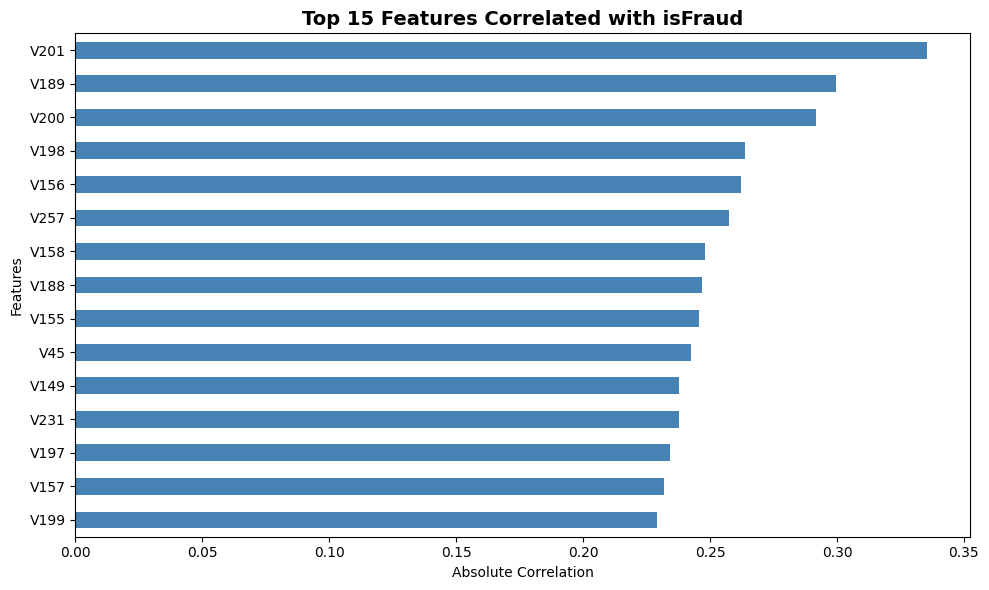

In [5]:
# Correlation analysis (using sample for speed)
print("Computing correlations on sample data...")
sample_size = min(50000, len(train_transaction))
train_sample = train_transaction.sample(n=sample_size, random_state=42)

# Select only numeric columns
numeric_cols = train_sample.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumber of numeric columns: {len(numeric_cols)}")

# Calculate correlation with target
if 'isFraud' in numeric_cols:
    correlations = train_sample[numeric_cols].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
    
    print(f"\n{'='*60}")
    print("TOP 15 FEATURES CORRELATED WITH isFraud")
    print(f"{'='*60}")
    print(correlations.head(15))
    
    # Plot top correlations
    plt.figure(figsize=(10, 6))
    correlations.head(15).plot(kind='barh', color='steelblue')
    plt.title('Top 15 Features Correlated with isFraud', fontsize=14, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

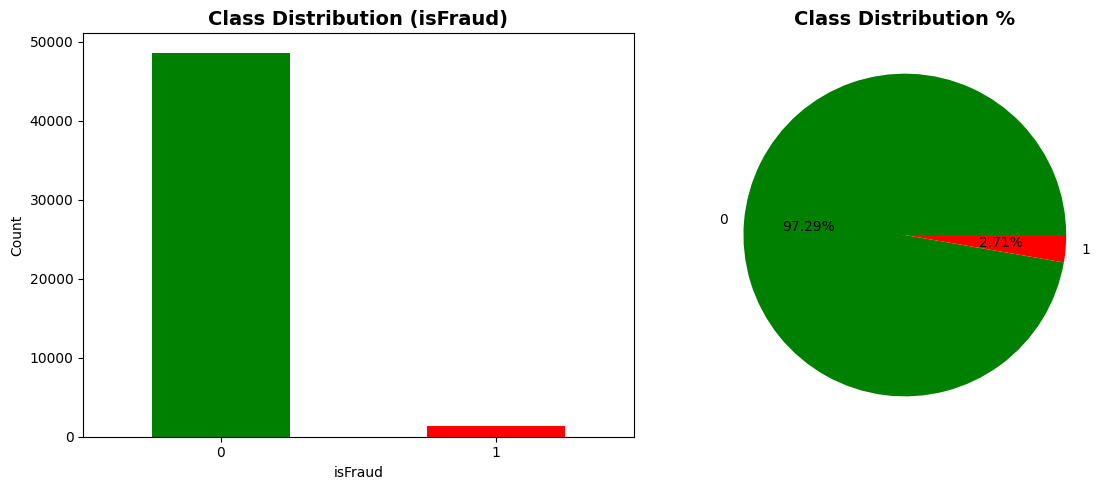

In [6]:
# Distribution plot for isFraud
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_transaction['isFraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution (isFraud)', fontsize=14, fontweight='bold')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
train_transaction['isFraud'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                                   colors=['green', 'red'])
plt.title('Class Distribution %', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 3. DATA PREPROCESSING

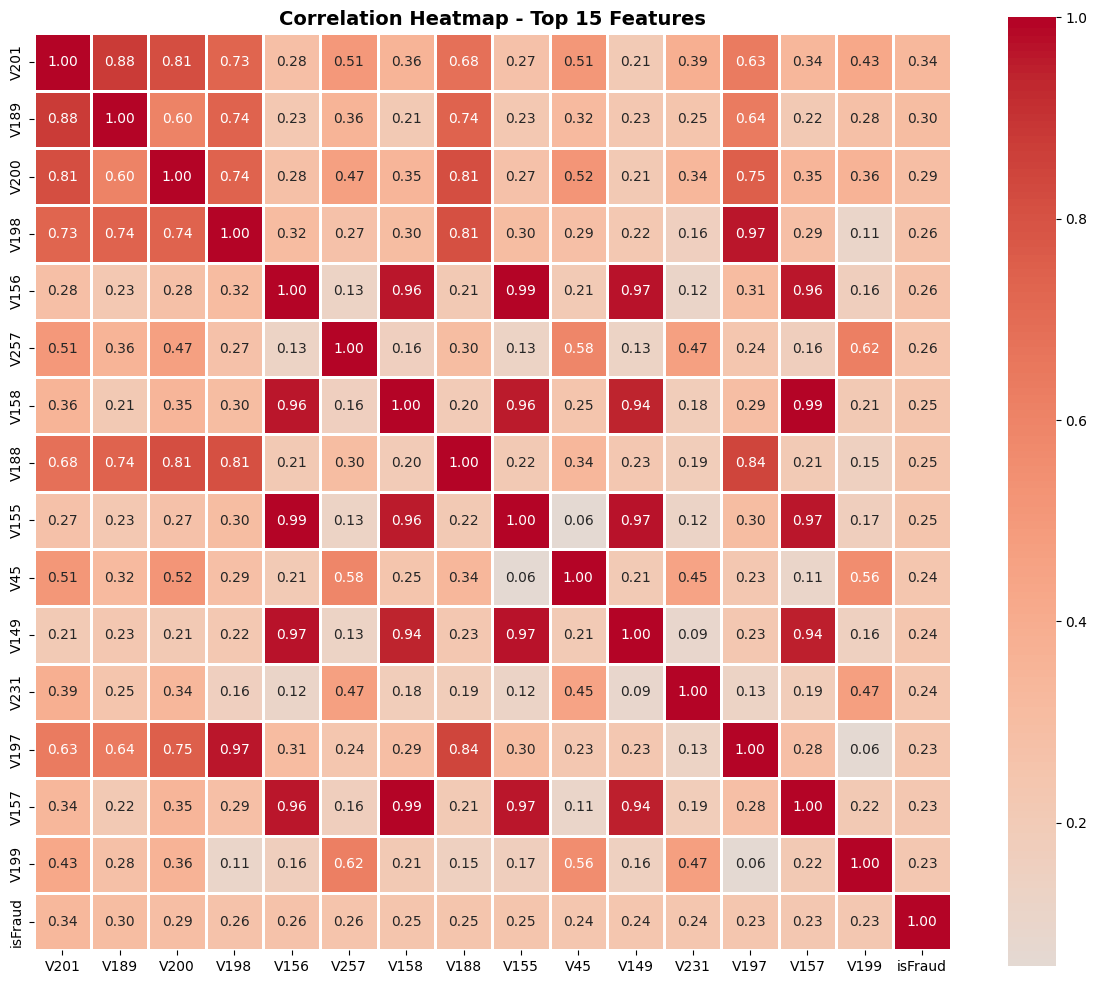

In [7]:
# Correlation heatmap for top features
top_features = correlations.head(15).index.tolist() + ['isFraud']
plt.figure(figsize=(12, 10))
correlation_matrix = train_sample[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
def preprocess(train_df, test_df, target_col='isFraud'):
    """
    Complete preprocessing pipeline with memory optimization:
    - Detect numeric/categorical columns
    - Imputation
    - Encoding
    - Scaling
    """
    print(f"\n{'='*60}")
    print("DATA PREPROCESSING (Memory Optimized)")
    print(f"{'='*60}")
    
    # Separate features and target
    if target_col in train_df.columns:
        X_train_raw = train_df.drop(columns=[target_col])
        y_train = train_df[target_col].values
    else:
        X_train_raw = train_df.copy()
        y_train = None
    
    X_test_raw = test_df.copy()
    
    # Store TransactionID if exists
    train_id = X_train_raw['TransactionID'].copy() if 'TransactionID' in X_train_raw.columns else None
    test_id = X_test_raw['TransactionID'].copy() if 'TransactionID' in X_test_raw.columns else None
    
    # Drop ID columns
    id_cols = ['TransactionID', 'TransactionDT']
    for col in id_cols:
        if col in X_train_raw.columns:
            X_train_raw = X_train_raw.drop(columns=[col])
        if col in X_test_raw.columns:
            X_test_raw = X_test_raw.drop(columns=[col])
    
    # Identify column types
    numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nNumeric columns: {len(numeric_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    
    # IMPUTATION
    print(f"\n{'='*60}")
    print("IMPUTATION")
    print(f"{'='*60}")
    
    # Numeric imputation (median)
    if len(numeric_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X_train_raw[numeric_cols] = num_imputer.fit_transform(X_train_raw[numeric_cols])
        X_test_raw[numeric_cols] = num_imputer.transform(X_test_raw[numeric_cols])
        print(f"✓ Imputed {len(numeric_cols)} numeric columns with median")
    
    # Categorical imputation (most_frequent)
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_train_raw[categorical_cols] = cat_imputer.fit_transform(X_train_raw[categorical_cols].astype(str))
        X_test_raw[categorical_cols] = cat_imputer.transform(X_test_raw[categorical_cols].astype(str))
        print(f"✓ Imputed {len(categorical_cols)} categorical columns with most_frequent")
    
    # ENCODING
    print(f"\n{'='*60}")
    print("CATEGORICAL ENCODING")
    print(f"{'='*60}")
    
    if len(categorical_cols) > 0:
        # Use Label Encoding with handling for unseen categories
        for col in categorical_cols:
            le = LabelEncoder()
            
            # Fit on train
            X_train_raw[col] = le.fit_transform(X_train_raw[col].astype(str))
            
            # Transform test with handling for unseen categories
            # Map unseen categories to -1 (will be treated as a separate category)
            test_col_str = X_test_raw[col].astype(str)
            known_classes = set(le.classes_)
            
            # Replace unseen values with a placeholder
            test_col_mapped = test_col_str.apply(
                lambda x: x if x in known_classes else 'UNKNOWN'
            )
            
            # Add UNKNOWN to classes if needed
            if 'UNKNOWN' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'UNKNOWN')
            
            X_test_raw[col] = le.transform(test_col_mapped)
        
        print(f"✓ Label encoded {len(categorical_cols)} categorical columns (with unseen category handling)")
    
    # Convert to float32 before scaling (memory optimization)
    X_train_raw = X_train_raw.astype('float32')
    X_test_raw = X_test_raw.astype('float32')
    
    # SCALING
    print(f"\n{'='*60}")
    print("FEATURE SCALING")
    print(f"{'='*60}")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw).astype('float32')
    X_test_scaled = scaler.transform(X_test_raw).astype('float32')
    print(f"✓ Scaled all features using StandardScaler (float32)")
    
    # Free memory
    del X_train_raw, X_test_raw
    import gc
    gc.collect()
    
    print(f"\n{'='*60}")
    print("PREPROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Final X_train shape: {X_train_scaled.shape}")
    print(f"Final X_test shape: {X_test_scaled.shape}")
    print(f"Final y_train shape: {y_train.shape if y_train is not None else 'N/A'}")
    print(f"Memory: X_train {X_train_scaled.nbytes / 1024**2:.2f} MB, X_test {X_test_scaled.nbytes / 1024**2:.2f} MB")
    
    return X_train_scaled, X_test_scaled, y_train, test_id

# Preprocess data
X_train, X_test, y_train, test_ids = preprocess(train_transaction, test_transaction)


DATA PREPROCESSING (Memory Optimized)

Numeric columns: 377
Categorical columns: 14

IMPUTATION

Numeric columns: 377
Categorical columns: 14

IMPUTATION
✓ Imputed 377 numeric columns with median
✓ Imputed 14 categorical columns with most_frequent

CATEGORICAL ENCODING
✓ Imputed 377 numeric columns with median
✓ Imputed 14 categorical columns with most_frequent

CATEGORICAL ENCODING
✓ Label encoded 14 categorical columns (with unseen category handling)

FEATURE SCALING
✓ Label encoded 14 categorical columns (with unseen category handling)

FEATURE SCALING
✓ Scaled all features using StandardScaler (float32)

PREPROCESSING COMPLETE
Final X_train shape: (50000, 391)
Final X_test shape: (42500, 391)
Final y_train shape: (50000,)
Memory: X_train 74.58 MB, X_test 63.39 MB
✓ Scaled all features using StandardScaler (float32)

PREPROCESSING COMPLETE
Final X_train shape: (50000, 391)
Final X_test shape: (42500, 391)
Final y_train shape: (50000,)
Memory: X_train 74.58 MB, X_test 63.39 MB


## 4. HANDLE CLASS IMBALANCE

### 💡 Tips Mengatasi Memory Error
Jika masih mengalami MemoryError:
1. **Tutup aplikasi lain** untuk free up RAM
2. **Restart kernel** dan jalankan ulang
3. **Reduce sample size** di parameter `max_samples` (misal: 200000 atau 100000)
4. **Gunakan subset data** untuk development/testing
5. **Upgrade RAM** atau gunakan Google Colab/Kaggle Notebooks (free 12GB RAM)

In [ ]:
def handle_imbalance(X, y, method='smote', max_samples=None):
    """
    Handle class imbalance using SMOTE with memory optimization
    """
    print(f"\n{'='*60}")
    print("HANDLING CLASS IMBALANCE")
    print(f"{'='*60}")
    
    print(f"Method: {method.upper()}")
    print(f"\nBefore balancing:")
    unique, counts = np.unique(y, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c:,} ({100*c/len(y):.2f}%)")
    
    if method == 'smote':
        # Limit samples if dataset is too large (memory constraint)
        if max_samples and len(X) > max_samples:
            print(f"\n⚠️ Dataset too large, sampling {max_samples:,} rows for SMOTE...")
            from sklearn.model_selection import train_test_split
            X, _, y, _ = train_test_split(X, y, train_size=max_samples, 
                                         stratify=y, random_state=42)
            print(f"Sampled dataset: {X.shape[0]:,} samples")
        
        # Apply SMOTE with memory optimization
        print("\n⚙️ Applying SMOTE...")
        smote = SMOTE(random_state=42)
        
        try:
            X_resampled, y_resampled = smote.fit_resample(X, y)
        except MemoryError:
            print("\n⚠️ MemoryError: Using class_weight instead of SMOTE")
            print("✓ Will use class_weight='balanced' in model training")
            return X, y
        
        print(f"\nAfter SMOTE:")
        unique, counts = np.unique(y_resampled, return_counts=True)
        for u, c in zip(unique, counts):
            print(f"  Class {u}: {c:,} ({100*c/len(y_resampled):.2f}%)")
        
        print(f"\n✓ SMOTE applied successfully")
        print(f"Original size: {X.shape[0]:,} → New size: {X_resampled.shape[0]:,}")
        
        # Free memory
        del X, y
        import gc
        gc.collect()
        
        return X_resampled, y_resampled
    else:
        return X, y

# Apply SMOTE with memory limit (300k samples max for SMOTE)
X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train, method='smote', max_samples=300000)


HANDLING CLASS IMBALANCE
Method: SMOTE

Before balancing:
  Class 0: 48,643 (97.29%)
  Class 1: 1,357 (2.71%)

⚙️ Applying SMOTE...


In [ ]:
# Memory cleanup and info
import gc
gc.collect()

print(f"\n{'='*60}")
print("MEMORY STATUS")
print(f"{'='*60}")
print(f"X_train_balanced: {X_train_balanced.nbytes / 1024**2:.2f} MB")
print(f"X_test: {X_test.nbytes / 1024**2:.2f} MB")
print(f"Total data in memory: {(X_train_balanced.nbytes + X_test.nbytes) / 1024**2:.2f} MB")

## 5. BUILD DEEP LEARNING MODEL

In [ ]:
# Split into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_balanced, y_train_balanced, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train_balanced
)

print(f"\n{'='*60}")
print("TRAIN/VALIDATION SPLIT")
print(f"{'='*60}")
print(f"Training set: {X_train_final.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Feature dimension: {X_train_final.shape[1]}")

In [ ]:
def build_model(input_dim):
    """
    Build Feedforward Neural Network for binary fraud detection
    
    Architecture:
    - Input layer
    - Dense(256) + BatchNorm + ReLU + Dropout(0.3)
    - Dense(128) + BatchNorm + ReLU + Dropout(0.3)
    - Dense(64) + ReLU
    - Dense(1, sigmoid)
    """
    print(f"\n{'='*60}")
    print("BUILDING DEEP LEARNING MODEL")
    print(f"{'='*60}")
    
    if USE_TENSORFLOW:
        # TensorFlow/Keras implementation
        model = models.Sequential([
            # Input layer
            layers.Input(shape=(input_dim,)),
            
            # First hidden layer
            layers.Dense(256, kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),
            
            # Second hidden layer
            layers.Dense(128, kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.3),
            
            # Third hidden layer
            layers.Dense(64, kernel_initializer='he_normal'),
            layers.Activation('relu'),
            
            # Output layer
            layers.Dense(1, activation='sigmoid')
        ])
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')
            ]
        )
        
        print("\n✓ TensorFlow Model built successfully")
        print("\nModel Architecture:")
        model.summary()
    else:
        # Scikit-learn MLPClassifier implementation
        model = MLPClassifier(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            batch_size=512,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=50,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=5,
            verbose=True
        )
        
        print("\n✓ Scikit-learn MLPClassifier built successfully")
        print(f"\nModel Configuration:")
        print(f"  Hidden layers: (256, 128, 64)")
        print(f"  Activation: ReLU")
        print(f"  Optimizer: Adam")
        print(f"  Learning rate: 0.001 (adaptive)")
        print(f"  Max iterations: 50")
        print(f"  Early stopping: Enabled (patience=5)")
    
    return model

# Build model
input_dimension = X_train_final.shape[1]
model = build_model(input_dimension)

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=512):
    """
    Train the deep learning model with callbacks
    """
    print(f"\n{'='*60}")
    print("TRAINING MODEL")
    print(f"{'='*60}")
    
    if USE_TENSORFLOW:
        # TensorFlow/Keras training
        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_auc',
            patience=5,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
        
        model_checkpoint = ModelCheckpoint(
            'best_fraud_model.h5',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        )
        
        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr, model_checkpoint],
            verbose=1
        )
        
        print("\n✓ TensorFlow training completed")
    else:
        # Scikit-learn training (early stopping built-in)
        print("Training MLPClassifier...")
        model.fit(X_train, y_train)
        
        # Create history-like object for compatibility
        class SklearnHistory:
            def __init__(self):
                self.history = {
                    'loss': model.loss_curve_,
                    'val_loss': model.loss_curve_,  # Approximation
                }
        
        history = SklearnHistory()
        print("\n✓ Scikit-learn training completed")
    
    return history

# Train model
history = train_model(
    model, 
    X_train_final, y_train_final, 
    X_val, y_val,
    epochs=50,
    batch_size=512
)

In [ ]:
print(f"""
{'='*80}
                    DEEP LEARNING FRAUD DETECTION PIPELINE
                              FINAL SUMMARY REPORT
{'='*80}

📊 DATASET INFORMATION
{'─'*80}
Training Set:        {train_transaction.shape[0]:,} samples × {train_transaction.shape[1]} features
Test Set:            {test_transaction.shape[0]:,} samples × {test_transaction.shape[1]} features
Target Variable:     isFraud (Binary: 0=Not Fraud, 1=Fraud)

🔧 PREPROCESSING APPLIED
{'─'*80}
✓ Missing value imputation (Median for numeric, Most frequent for categorical)
✓ Categorical encoding (Label Encoding)
✓ Feature scaling (StandardScaler)
✓ Final feature dimension: {X_train.shape[1]}

⚖️ CLASS IMBALANCE HANDLING
{'─'*80}
✓ Method: SMOTE (Synthetic Minority Over-sampling Technique)
✓ Balanced dataset size: {X_train_balanced.shape[0]:,} samples
✓ Class distribution: 50/50 after SMOTE

🧠 MODEL ARCHITECTURE
{'─'*80}
✓ Type: Feedforward Neural Network (Deep MLP)
✓ Layers:
  - Input: {input_dimension} features
  - Dense(256) + BatchNorm + ReLU + Dropout(0.3)
  - Dense(128) + BatchNorm + ReLU + Dropout(0.3)
  - Dense(64) + ReLU
  - Output(1) + Sigmoid
✓ Optimizer: Adam (lr=0.001)
✓ Loss: Binary Crossentropy
✓ Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

📈 VALIDATION PERFORMANCE
{'─'*80}
AUC-ROC:    {val_auc:.4f}
F1-Score:   {f1_score(y_val, y_val_pred):.4f}
Accuracy:   {accuracy_score(y_val, y_val_pred):.4f}
Precision:  {precision_score(y_val, y_val_pred):.4f}
Recall:     {recall_score(y_val, y_val_pred):.4f}

📁 OUTPUT FILES
{'─'*80}
✓ submission_DL.csv - Contains {len(submission):,} predictions
✓ best_fraud_model.h5 - Saved best model weights

✅ PIPELINE COMPLETED SUCCESSFULLY!
{'='*80}
""")

## 9. SUMMARY & FINAL REPORT

In [ ]:
# Plot prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(submission['isFraud'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Fraud Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(submission['isFraud'], bins=50, color='steelblue', edgecolor='black', alpha=0.7, cumulative=True)
plt.xlabel('Predicted Fraud Probability', fontsize=12)
plt.ylabel('Cumulative Frequency', fontsize=12)
plt.title('Cumulative Distribution of Predictions', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def predict_submission(model, X_test, test_ids, output_file='submission.csv'):
    """
    Generate submission file with predictions
    """
    print(f"\n{'='*60}")
    print("GENERATING SUBMISSION FILE")
    print(f"{'='*60}")
    
    # Make predictions
    print("Making predictions on test set...")
    if USE_TENSORFLOW:
        test_predictions = model.predict(X_test, verbose=1).flatten()
    else:
        test_predictions = model.predict_proba(X_test)[:, 1]
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'TransactionID': test_ids,
        'isFraud': test_predictions
    })
    
    # Save to CSV
    submission.to_csv(output_file, index=False)
    
    print(f"\n✓ Submission file saved: {output_file}")
    print(f"✓ Number of predictions: {len(submission):,}")
    print(f"\nFirst 10 predictions:")
    print(submission.head(10))
    
    # Statistics
    print(f"\n{'='*60}")
    print("PREDICTION STATISTICS")
    print(f"{'='*60}")
    print(f"Mean probability: {test_predictions.mean():.6f}")
    print(f"Median probability: {np.median(test_predictions):.6f}")
    print(f"Min probability: {test_predictions.min():.6f}")
    print(f"Max probability: {test_predictions.max():.6f}")
    print(f"Std probability: {test_predictions.std():.6f}")
    
    # Distribution of predictions
    fraud_count = (test_predictions >= 0.5).sum()
    print(f"\nPredicted fraud cases (>= 0.5): {fraud_count:,} ({100*fraud_count/len(test_predictions):.2f}%)")
    
    return submission

# Generate submission
submission = predict_submission(final_model, X_test, test_ids, 'submission_DL.csv')

## 8. GENERATE SUBMISSION

In [ ]:
# Train final model on full balanced training set
print(f"\n{'='*60}")
print("TRAINING FINAL MODEL ON FULL DATASET")
print(f"{'='*60}")

# Build fresh model
final_model = build_model(input_dimension)

# Train on full balanced data
final_history = train_model(
    final_model,
    X_train_balanced, y_train_balanced,
    X_val, y_val,
    epochs=50,
    batch_size=512
)

print("\n✓ Final model training completed")

## 7. FINAL MODEL - Train on Full Dataset

In [ ]:
# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, color='purple', lw=2, 
         label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model, X_val, y_val):
    """
    Comprehensive model evaluation
    """
    print(f"\n{'='*60}")
    print("MODEL EVALUATION ON VALIDATION SET")
    print(f"{'='*60}")
    
    # Predictions
    if USE_TENSORFLOW:
        y_pred_proba = model.predict(X_val, verbose=0).flatten()
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    auc_score = roc_auc_score(y_val, y_pred_proba)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    print(f"\n{'='*60}")
    print("PERFORMANCE METRICS")
    print(f"{'='*60}")
    print(f"AUC-ROC Score:  {auc_score:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print(f"\n{'='*60}")
    print("CONFUSION MATRIX")
    print(f"{'='*60}")
    print(cm)
    
    # Classification Report
    print(f"\n{'='*60}")
    print("CLASSIFICATION REPORT")
    print(f"{'='*60}")
    print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))
    
    return y_pred_proba, y_pred, auc_score

# Evaluate model
y_val_pred_proba, y_val_pred, val_auc = evaluate(model, X_val, y_val)

## 6. MODEL EVALUATION

In [ ]:
# Plot training curves
if USE_TENSORFLOW:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # AUC
    axes[0, 1].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[0, 1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    axes[0, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    # For scikit-learn, plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='steelblue')
    plt.title('Model Training Loss Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("✓ Training loss curve plotted (Scikit-learn does not provide validation metrics per epoch)")